# Bloomberg Data Processing Examples

This notebook demonstrates various use cases and examples for the Bloomberg data processing pipeline. We'll explore different scenarios and show how to effectively use the logging system to monitor and validate data processing.

## Contents
1. Basic Setup and Configuration
2. Credit Spread Analysis
3. Fixed Income Portfolio Analysis
4. Market Data Visualization
5. Error Handling and Edge Cases
6. Log Analysis and Monitoring

## 1. Basic Setup and Configuration

First, let's import the necessary modules and set up our logging system.

In [1]:
import sys
import os
from pathlib import Path
import yaml
import logging
import logging.config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up project paths
project_root = Path().absolute().parent
sys.path.append(str(project_root))

from src.core.bloomberg_fetcher import BloombergDataFetcher
from src.utils.csv_exporter import export_table_to_csv

In [4]:
def setup_logging():
    """Set up logging configuration."""
    config_path = project_root / 'config' / 'logging_config.yaml'
    
    # Create logs directory if it doesn't exist
    logs_dir = project_root / 'logs'
    logs_dir.mkdir(exist_ok=True)
    
    if config_path.exists():
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
            # Update log file paths to use absolute paths
            for handler in config['handlers'].values():
                if 'filename' in handler:
                    handler['filename'] = str(logs_dir / Path(handler['filename']).name)
            logging.config.dictConfig(config)
    else:
        logging.basicConfig(level=logging.INFO)
    
    # Create loggers for different components
    data_pipeline_logger = logging.getLogger('data_pipeline')
    bloomberg_logger = logging.getLogger('bloomberg')
    validation_logger = logging.getLogger('validation')
    
    return data_pipeline_logger, bloomberg_logger, validation_logger

# Set up logging
data_pipeline_logger, bloomberg_logger, validation_logger = setup_logging()

## 2. Credit Spread Analysis

Let's analyze credit spreads across different markets and ratings.

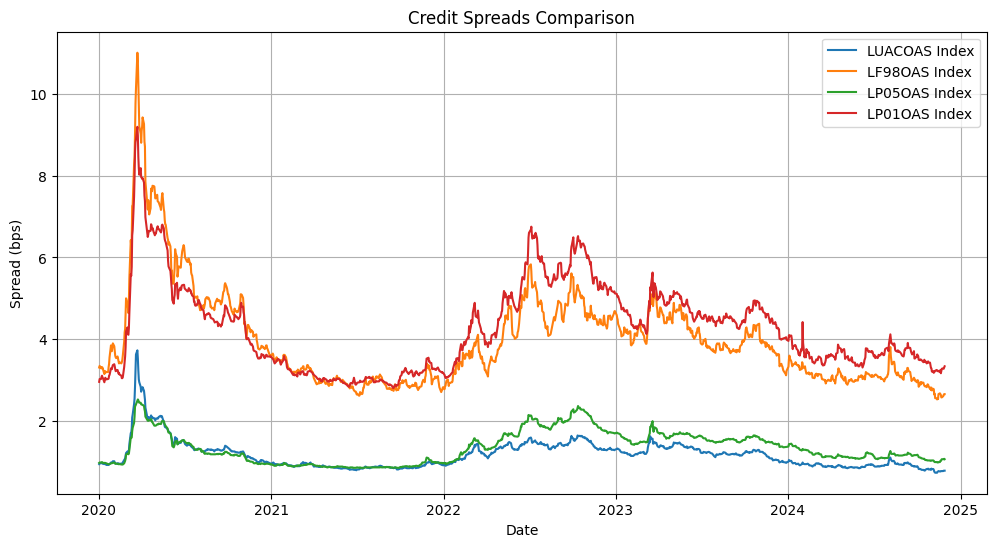

In [5]:
def fetch_credit_spreads(start_date="2020-01-01"):
    """Fetch credit spread data for analysis."""
    bloomberg_logger.info(f"Fetching credit spread data from {start_date}")
    
    config = {
        'settings': {
            'default_start_date': start_date,
            'default_end_date': '',
            'data_directory': 'data',
            'log_directory': 'logs'
        },
        'tickers': {
            'credit_spreads': {
                'us_ig': 'LUACOAS Index',
                'us_hy': 'LF98OAS Index',
                'eu_ig': 'LP05OAS Index',
                'eu_hy': 'LP01OAS Index'
            }
        }
    }
    
    fetcher = BloombergDataFetcher(
        tickers=list(config['tickers']['credit_spreads'].values()),
        fields=['PX_LAST'],
        start_date=start_date,
        logger=bloomberg_logger,
        config=config
    )
    
    return fetcher.run_pipeline()

# Fetch credit spread data
credit_spreads = fetch_credit_spreads()

# Plot the data
plt.figure(figsize=(12, 6))
for col in credit_spreads.columns:
    plt.plot(credit_spreads.index, credit_spreads[col], label=col)
plt.title('Credit Spreads Comparison')
plt.xlabel('Date')
plt.ylabel('Spread (bps)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Fixed Income Portfolio Analysis

Now let's analyze a fixed income portfolio with different bond characteristics.

In [ ]:
def analyze_bond_portfolio(bonds, start_date="2020-01-01"):
    """Analyze a portfolio of bonds."""
    bloomberg_logger.info(f"Analyzing bond portfolio with {len(bonds)} securities")
    
    fields = ['YLD_YTM_MID', 'DUR_MID', 'MTG', 'CPN']
    
    fetcher = BloombergDataFetcher(
        tickers=bonds,
        fields=fields,
        start_date=start_date,
        logger=bloomberg_logger
    )
    
    return fetcher.run_pipeline()

# Example bond portfolio
example_bonds = [
    'T 1.5 02/15/30 Govt',
    'C 4.45 09/29/27 Corp',
    'MSFT 2.921 03/17/25 Corp'
]

portfolio_data = analyze_bond_portfolio(example_bonds)

# Display portfolio characteristics
print("Portfolio Characteristics:")
print(portfolio_data.describe())

## 4. Market Data Visualization

Create advanced visualizations of market data relationships.

In [ ]:
def create_market_visualization(data):
    """Create advanced market data visualizations."""
    data_pipeline_logger.info("Creating market data visualizations")
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Market Data Correlations')
    plt.show()
    
    # Rolling correlations
    window = 60  # 60-day rolling window
    rolling_corr = data.rolling(window).corr()
    
    # Plot rolling correlations
    plt.figure(figsize=(12, 6))
    for col in data.columns:
        if col != data.columns[0]:
            plt.plot(data.index, rolling_corr[col][data.columns[0]], label=f'{col} vs {data.columns[0]}')
    
    plt.title(f'{window}-Day Rolling Correlations')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create visualizations for credit spread data
create_market_visualization(credit_spreads)

## 5. Error Handling and Edge Cases

Demonstrate how the system handles various error conditions and edge cases.

In [ ]:
def test_error_handling():
    """Test various error conditions and edge cases."""
    validation_logger.info("Testing error handling scenarios")
    
    # Test case 1: Invalid ticker
    try:
        fetcher = BloombergDataFetcher(
            tickers=['INVALID_TICKER'],
            fields=['PX_LAST'],
            start_date='2020-01-01',
            logger=bloomberg_logger
        )
        data = fetcher.run_pipeline()
    except Exception as e:
        validation_logger.error(f"Expected error with invalid ticker: {str(e)}")
    
    # Test case 2: Future start date
    try:
        fetcher = BloombergDataFetcher(
            tickers=['SPX Index'],
            fields=['PX_LAST'],
            start_date='2025-01-01',
            logger=bloomberg_logger
        )
        data = fetcher.run_pipeline()
    except Exception as e:
        validation_logger.error(f"Expected error with future start date: {str(e)}")

# Run error handling tests
test_error_handling()

## 6. Log Analysis and Monitoring

Analyze the log files to monitor system performance and data quality.

In [ ]:
def analyze_logs():
    """Analyze log files for insights."""
    log_files = {
        'data_pipeline': project_root / 'logs' / 'data_pipeline.log',
        'bloomberg': project_root / 'logs' / 'bloomberg.log',
        'validation': project_root / 'logs' / 'validation.log',
        'error': project_root / 'logs' / 'error.log'
    }
    
    for log_name, log_path in log_files.items():
        if log_path.exists():
            print(f"\n=== {log_name.upper()} LOG ANALYSIS ===")
            with open(log_path, 'r') as f:
                logs = f.readlines()
                print(f"Total log entries: {len(logs)}")
                
                # Count log levels
                levels = {'INFO': 0, 'WARNING': 0, 'ERROR': 0}
                for line in logs:
                    for level in levels:
                        if f" - {level} - " in line:
                            levels[level] += 1
                
                print("\nLog Level Distribution:")
                for level, count in levels.items():
                    print(f"{level}: {count}")

# Analyze logs
analyze_logs()